# 采用传统时间序列预测方法ARIMA预测价格走势
* Zansong Zhu

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import timedelta, datetime

import lseg.data as ld

import pandas as pd

import matplotlib

import matplotlib.pyplot as plt

import numpy as np

import warnings

In [32]:
#function to forecast using ARIMA Model

#input is time series data frame(df) got from eikon.get_timeseries(..)

#and forecast end date which is in format yyyy-mm-dd

def ARIMA_model_forecast(df, forecast_end_date):
    #Set the start and end forecast date time
    #first date is 1 day after time series. The last date is the forecast_end_date parameter
    _e_date = datetime.fromtimestamp(datetime.timestamp(df.index[-1]))

    e_date = _e_date + timedelta(days=1)

    e_date = e_date.strftime('%Y-%m-%d')

    decomposition = seasonal_decompose(df.CLOSE, period=1)

    trend = decomposition.trend

    seasonal = decomposition.seasonal

    residual = decomposition.resid

    #find differences of time series which is input of ARIMA model

    df['spot_1diff'] = df['CLOSE'].diff()

    df = df[df['spot_1diff'].notnull()]# drop null rows

    nobs = len(df['CLOSE'])
    
    nlags = min(50, nobs-1)
    
    print(nlags)
    
    lag_acf = acf(df['spot_1diff'], nlags=nlags)

    lag_pacf = pacf(df['spot_1diff'], nlags=nlags, method='ols')

    new_spot = df['spot_1diff'].resample('D').ffill()# resample per day and fill the gaps

    new_spot = new_spot.bfill()

    new_spot = new_spot.astype('float')

    #call ARIMA model which p=1,d=0 and q=1 with differences of time series  

    arma_model = ARIMA(new_spot, order=(1, 0, 1))

    results = arma_model.fit()

    #focast time series

    residuals = pd.DataFrame(results.resid)

    predictions_ARIMA = pd.Series(results.fittedvalues, copy=True)

    predictions_ARIMA_cumsum = predictions_ARIMA.cumsum()

    predictions_ARIMA_final = pd.Series(
        df['CLOSE'].iloc[0],
        index=new_spot.index
    )
    
    predictions_ARIMA_final = predictions_ARIMA_final.add(predictions_ARIMA_cumsum, fill_value=0)

    new_spot = df.CLOSE.resample('D',label='right').ffill().astype('float')

    es_model = ExponentialSmoothing(new_spot,
                                    trend='add',
                                    damped=False,
                                    seasonal='mul',
                                    seasonal_periods=30)

    es_results = es_model.fit()

    predicted_values = es_model.predict(
        params=es_results.params,
        start=e_date, end=forecast_end_date)

    #create data frame from forecast timeseries  

    preds = pd.DataFrame(
        index=pd.date_range(start=e_date, end=forecast_end_date),
        data=predicted_values,
        columns=['CLOSE']
    )

    #Plot graph of past and forecast timeseries
    plt.figure(figsize=(16, 7))

    plt.plot(new_spot, label='Actual')

    plt.plot(preds, label='Forecast', color='pink')

    plt.legend(loc='best')

    plt.show()
    return preds

In [22]:
import lseg.data as ld

import pandas as pd

In [23]:
ld.open_session()

<lseg.data.session.Definition object at 0x7fc2955c6190 {name='codebook'}>

In [34]:
ric = "EUR="
start_date = '2025-01-01'
fields = ['BID']
df = ld.get_history(
    universe=ric,
    fields=fields,
    interval='daily',
    start=start_date,
    count = 10000)

In [35]:
df.rename(
    columns= {
        'BID':'CLOSE'
    },
    inplace= True
)

df.head(10)

EUR=,CLOSE
Date,
2025-01-02,1.0265
2025-01-03,1.0308
2025-01-06,1.039
2025-01-07,1.0339
2025-01-08,1.0318
2025-01-09,1.0298
2025-01-10,1.0244
2025-01-13,1.0244
2025-01-14,1.0307


50


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743:ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


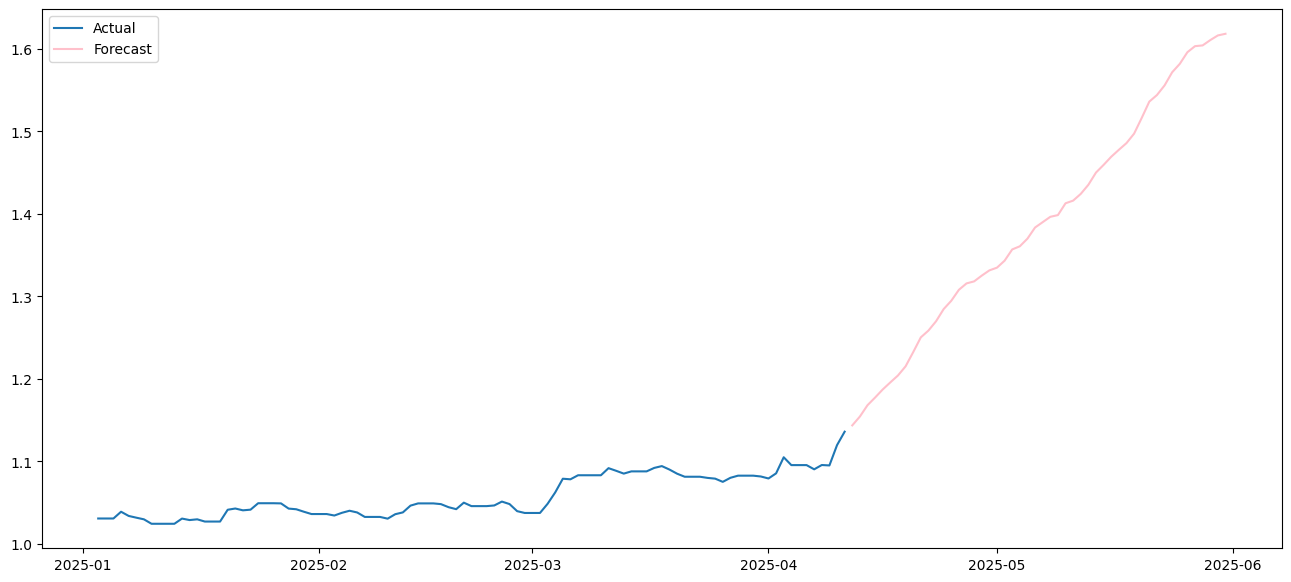

,CLOSE
2025-04-12,1.143627
2025-04-13,1.154331
2025-04-14,1.168084
2025-04-15,1.177398
2025-04-16,1.187161
2025-04-17,1.195757
2025-04-18,1.204108
2025-04-19,1.215181
2025-04-20,1.232390
2025-04-21,1.250298


In [41]:
forecast_end_date = '2025-5-31'

#call the function to forecast time series with ARIMA model

forecast = ARIMA_model_forecast(df,forecast_end_date)

#display forecast time series

forecast